In [93]:
import seaborn as sns
import pandas as pd 
import datetime as datetime
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
import json
from scipy.stats import spearmanr
# Read data from file 'filename.csv' |
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later)
pd.options.display.float_format = '{:,.2f}'.format
# data = pd.read_csv("/home/anconam/projects/Shapley_Pruning/experiments/results/fmnist__sv-smallest_gap:10.0_steps:10_start:1_int:1.csv") 
# data = pd.read_csv("/home/anconam/projects/Shapley_Pruning/experiments/results/fmnist__count-smallest_gap:5.0_steps:10_start:1_int:1.csv") 
data = pd.read_csv("/home/anconam/projects/Shapley_Pruning/experiments/results/fmnist__count-smallest_gap:1.0_steps:25_start:1_int:1.csv") 
data.head()

,ranking_method,layer,max_loss_increase,epoch,full_loss,loss_history,indices,scores,k
0,count-smallest,fc1,1.00,1,0.32,"[0.31647393107414246, 0.3164024353027344, 0.31...","[1040, 3073, 4026, 2930, 1862, 2465, 3522, 133...","[0, 0, 0, 0, 0, 2, 4, 6, 14, 15, 15, 20, 25, 2...",897
1,count-smallest,conv2,1.00,2,0.30,"[0.303020715713501, 0.30452269315719604, 0.305...","[44, 52, 7, 63, 11, 27, 60, 6, 61, 49, 13, 51,...","[251274, 313791, 970375, 1026048, 1266146, 130...",3
2,count-smallest,conv1,1.00,3,0.25,"[0.24926812946796417, 0.24962496757507324, 0.2...","[10, 11, 29, 9, 13, 24, 16, 18, 27, 20, 7, 17,...","[607054, 855389, 1110755, 1829484, 4078676, 52...",3
3,count-smallest,fc1,1.00,4,0.26,"[0.2614539563655853, 0.261345237493515, 0.2608...","[54, 1998, 959, 2070, 687, 2854, 2963, 3032, 5...","[1, 1, 13, 21, 24, 34, 36, 37, 91, 114, 121, 1...",45
4,count-smallest,conv2,1.00,5,0.24,"[0.2445490062236786, 0.2469087392091751, 0.248...","[60, 26, 10, 57, 47, 35, 12, 58, 6, 24, 55, 39...","[62329, 593709, 721486, 976295, 997585, 102333...",2


SpearmanrResult(correlation=0.31065094729794696, pvalue=2.5448373632041897e-92)
SpearmanrResult(correlation=0.1588179401827587, pvalue=1.6373186523885569e-19)
SpearmanrResult(correlation=0.14117418041010224, pvalue=1.6666649597128024e-15)
SpearmanrResult(correlation=0.14204582926510767, pvalue=1.6677444413084056e-15)
SpearmanrResult(correlation=0.1264890133582381, pvalue=2.34857620837333e-12)
SpearmanrResult(correlation=0.13432145496578546, pvalue=1.1866362580950023e-13)
SpearmanrResult(correlation=0.0778747722543249, pvalue=1.886538617278236e-05)
SpearmanrResult(correlation=0.2472045807228309, pvalue=1.006562832278397e-40)
SpearmanrResult(correlation=0.23618753503327108, pvalue=1.6908295793112606e-36)
SpearmanrResult(correlation=0.31065094729794696, pvalue=2.5448373632041897e-92)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SpearmanrResult(correlation=0.1588179401827587, pvalue=1.6373186523885569e-19)
SpearmanrResult(correlation=0.14117418041010224, pvalue=1.6666649597128024e-15)
SpearmanrResult(correlation=0.14204582926510767, pvalue=1.6677444413084056e-15)
SpearmanrResult(correlation=0.1264890133582381, pvalue=2.34857620837333e-12)
SpearmanrResult(correlation=0.13432145496578546, pvalue=1.1866362580950023e-13)
SpearmanrResult(correlation=0.0778747722543249, pvalue=1.886538617278236e-05)
SpearmanrResult(correlation=0.2472045807228309, pvalue=1.006562832278397e-40)
SpearmanrResult(correlation=0.23618753503327108, pvalue=1.6908295793112606e-36)
SpearmanrResult(correlation=0.31065094729794696, pvalue=2.5448373632041897e-92)
SpearmanrResult(correlation=0.1588179401827587, pvalue=1.6373186523885569e-19)
SpearmanrResult(correlation=0.14117418041010224, pvalue=1.6666649597128024e-15)
SpearmanrResult(correlation=0.14204582926510767, pvalue=1.6677444413084056e-15)
SpearmanrResult(correlation=0.1264890133582381, p

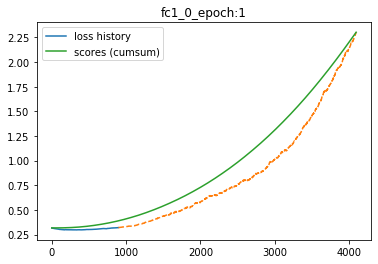

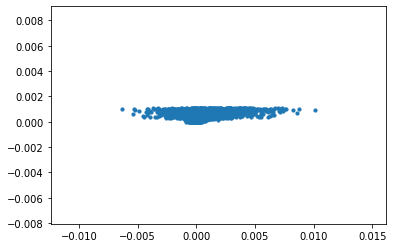

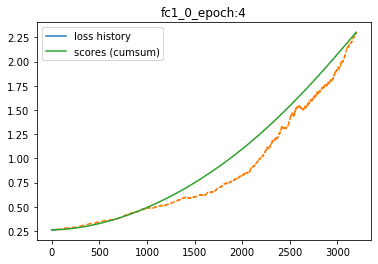

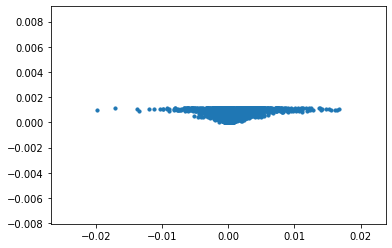

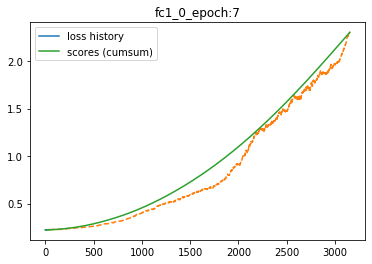

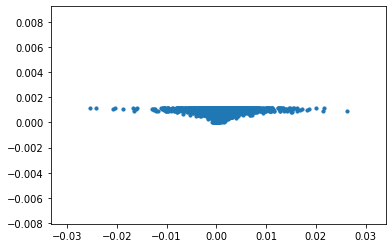

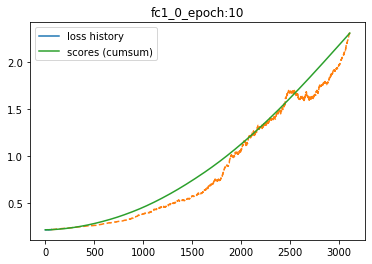

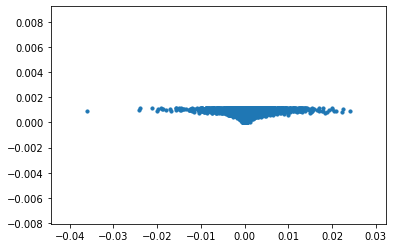

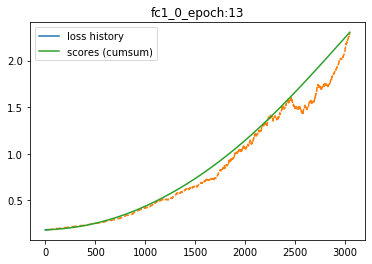

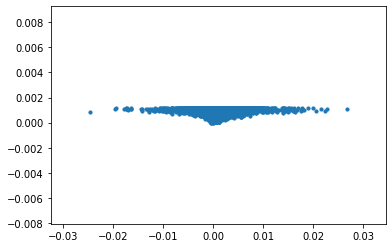

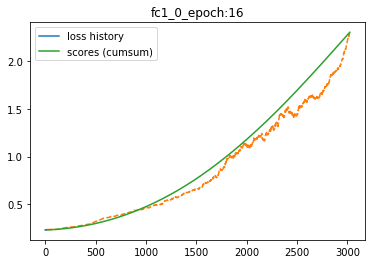

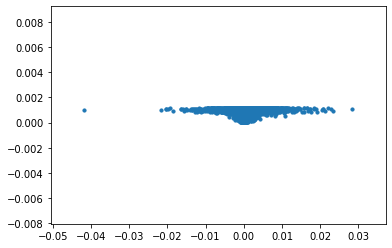

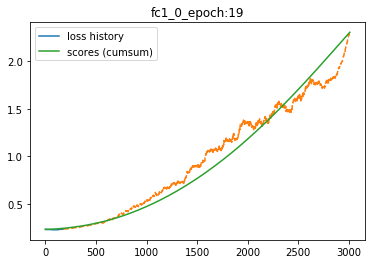

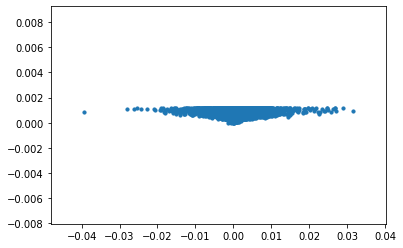

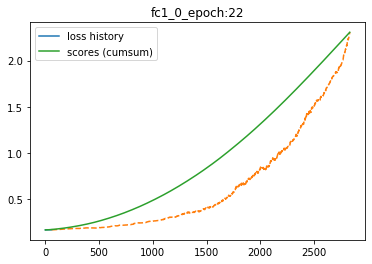

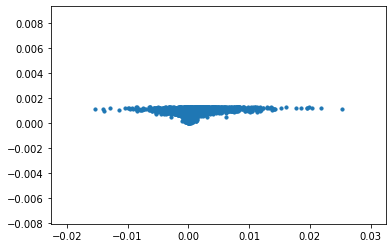

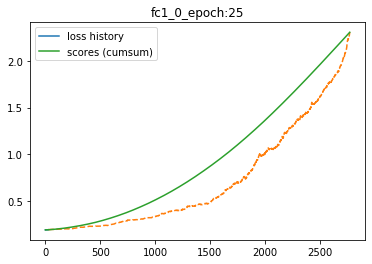

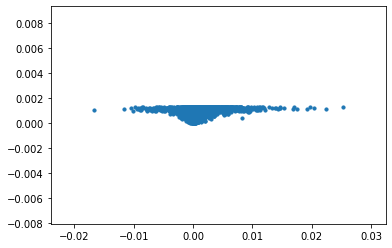

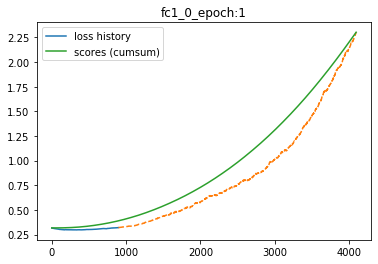

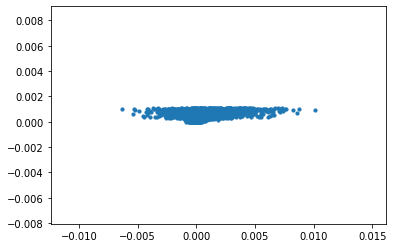

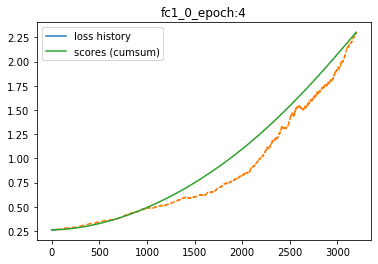

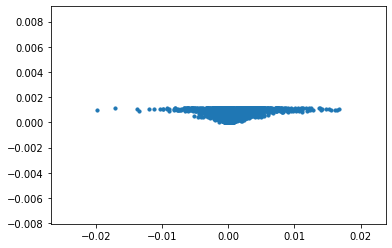

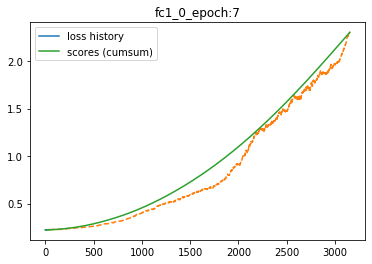

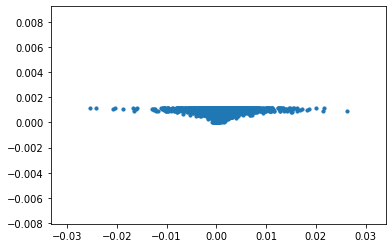

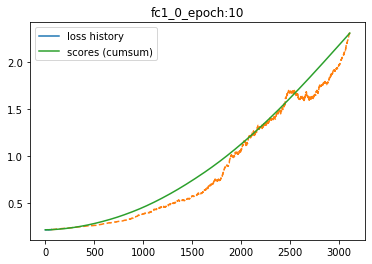

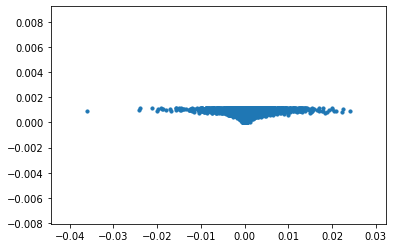

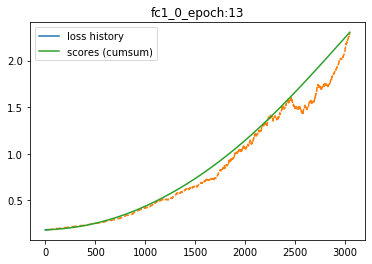

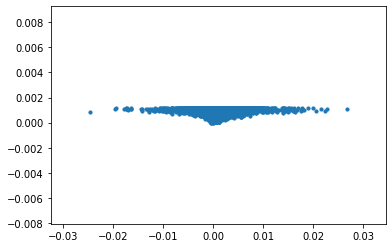

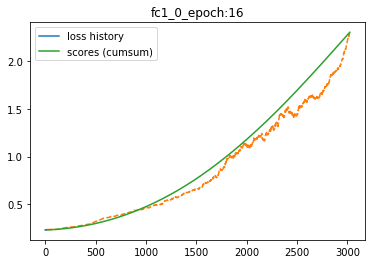

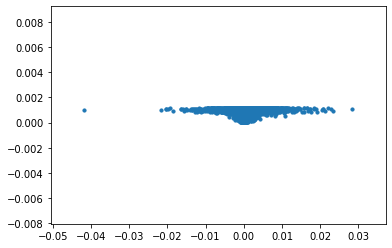

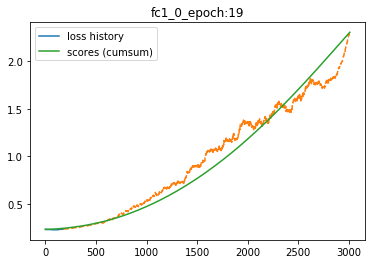

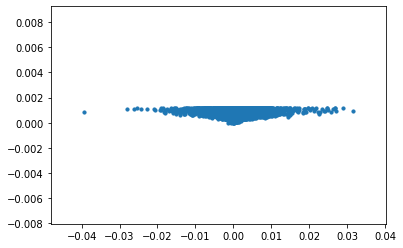

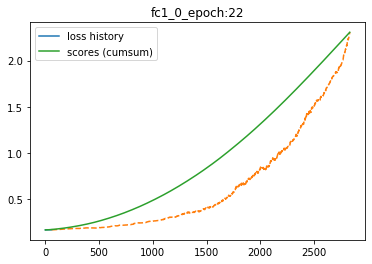

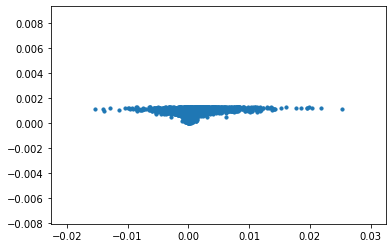

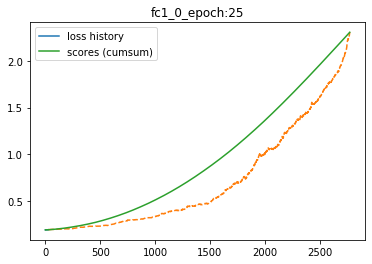

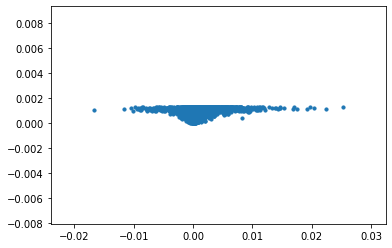

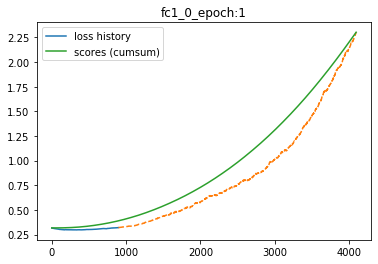

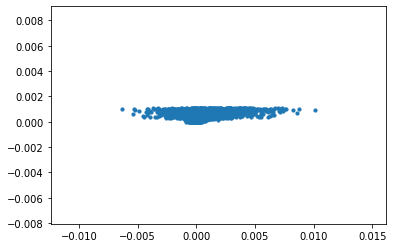

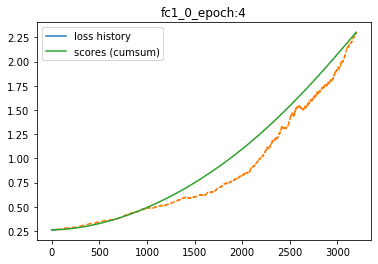

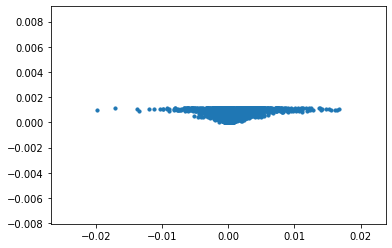

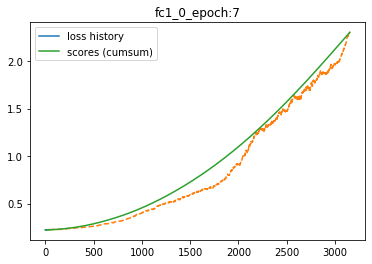

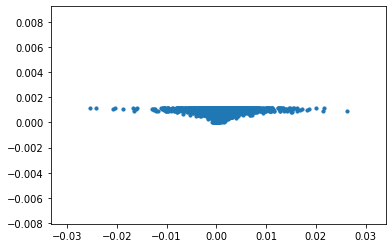

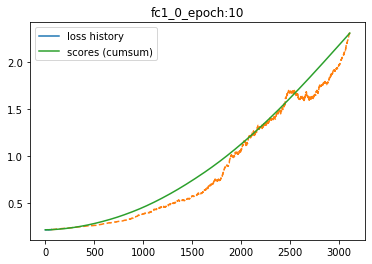

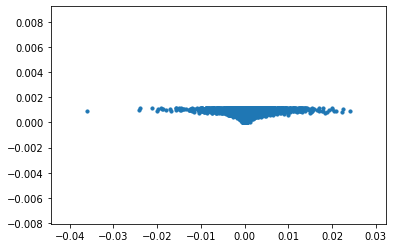

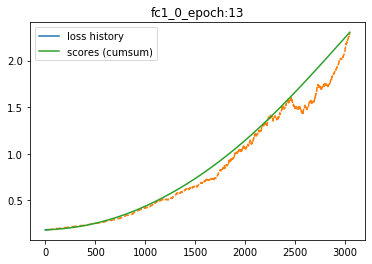

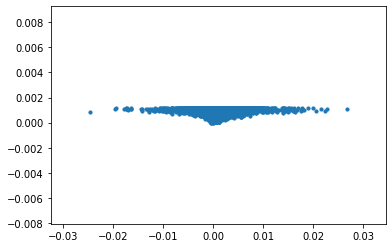

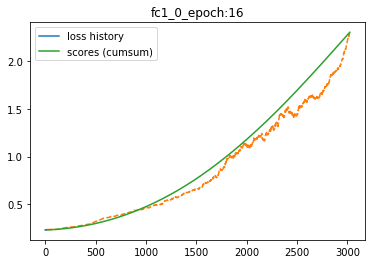

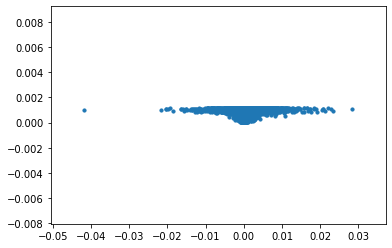

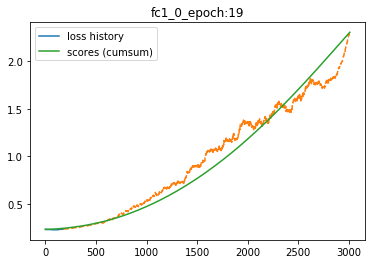

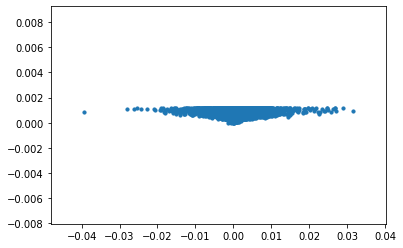

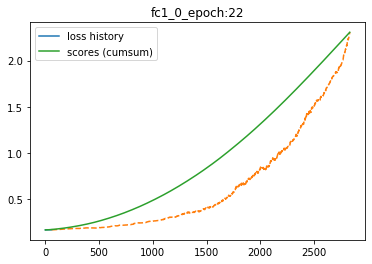

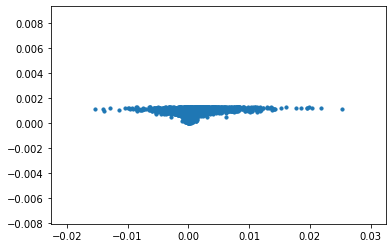

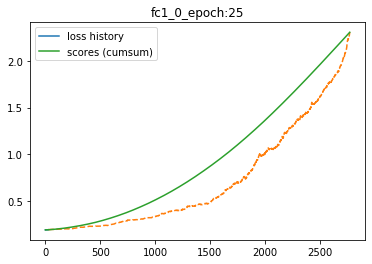

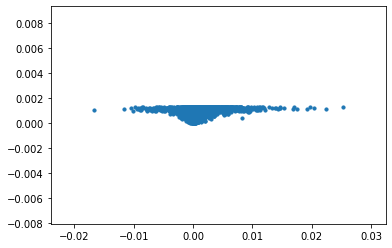

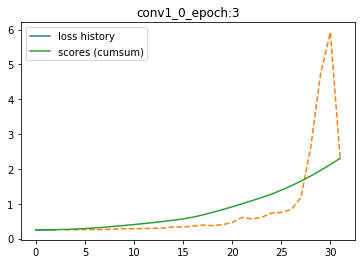

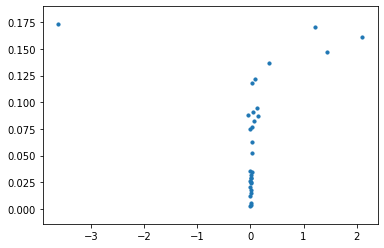

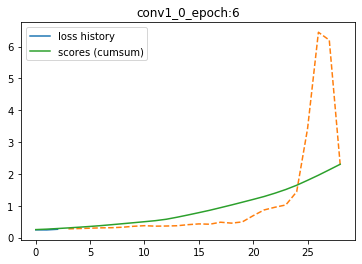

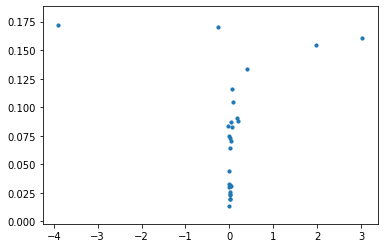

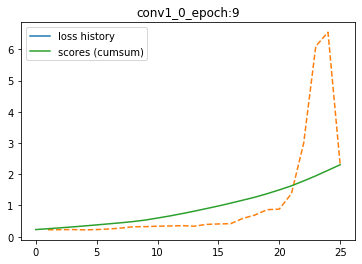

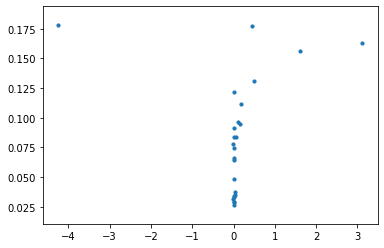

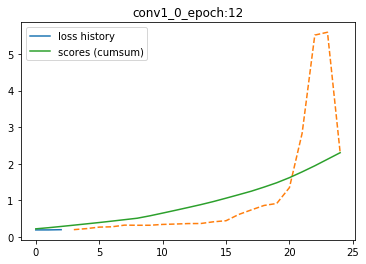

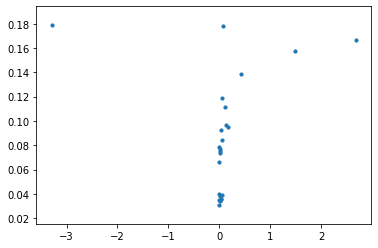

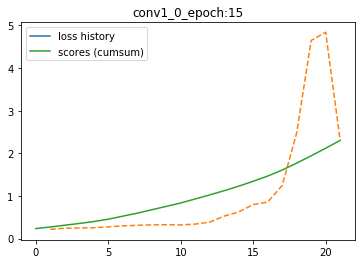

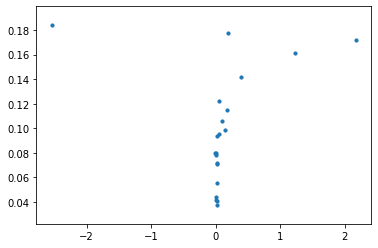

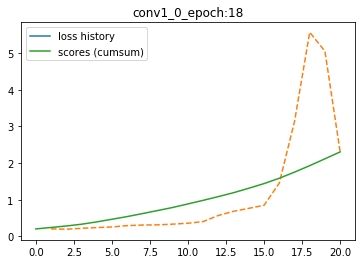

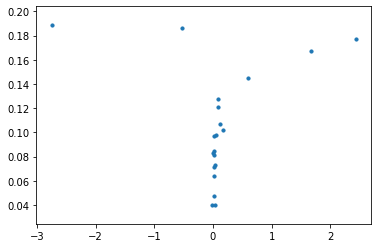

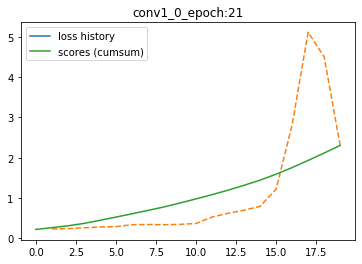

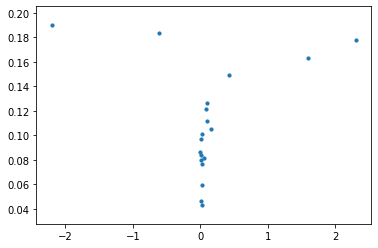

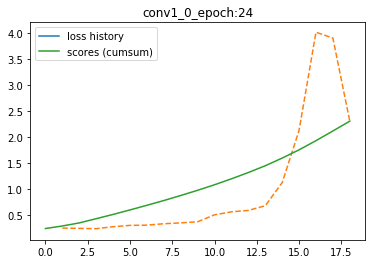

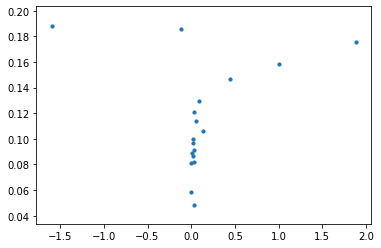

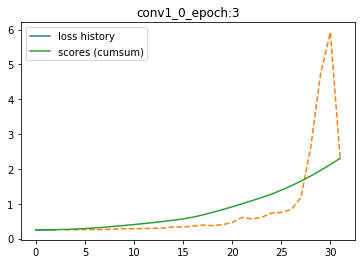

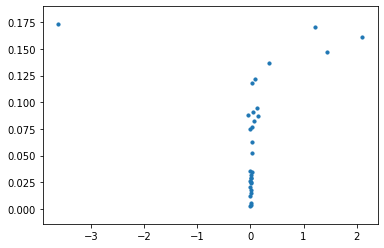

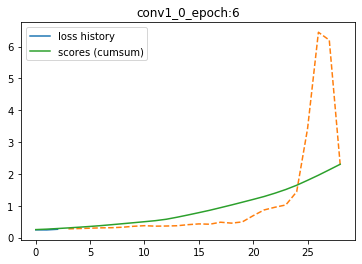

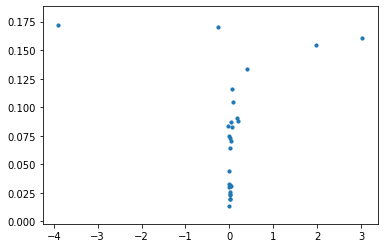

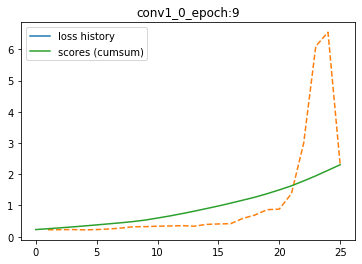

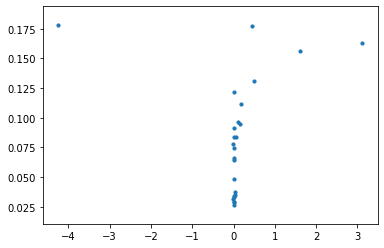

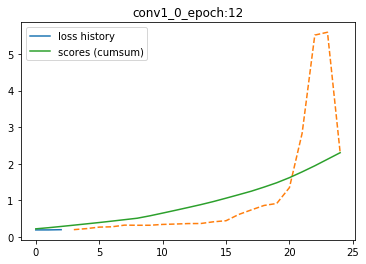

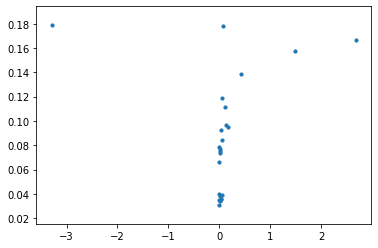

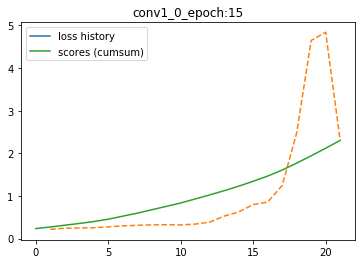

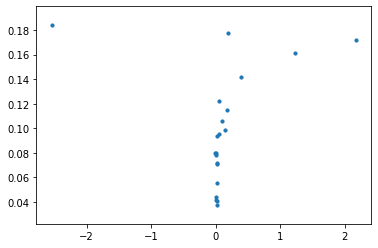

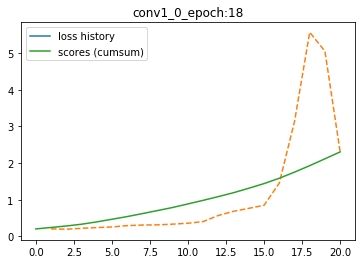

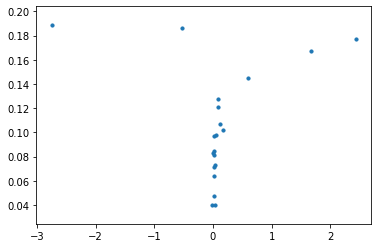

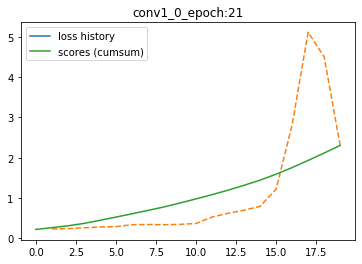

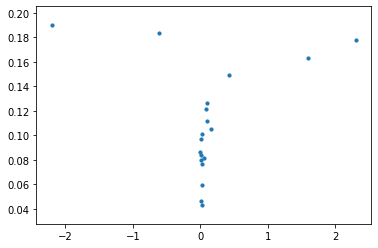

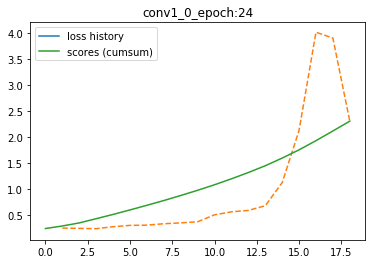

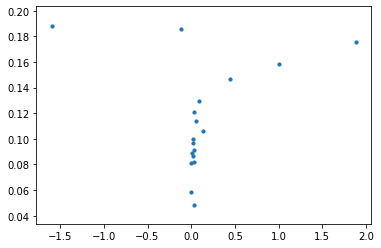

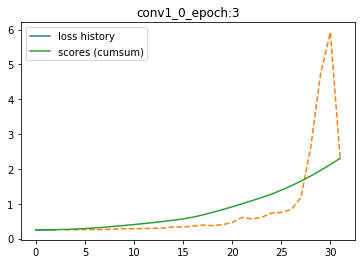

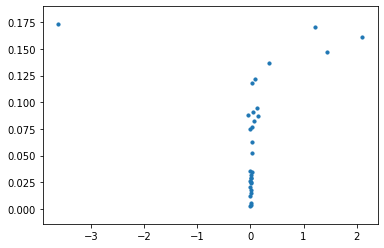

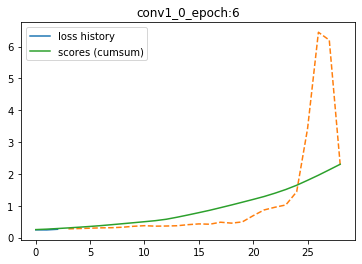

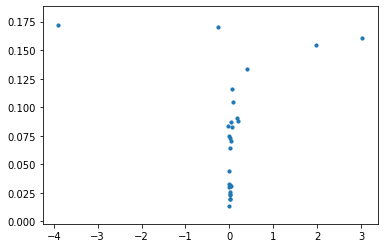

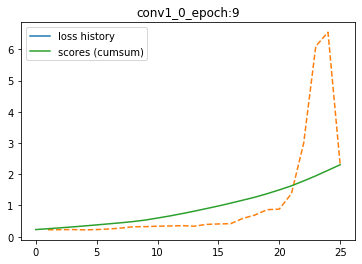

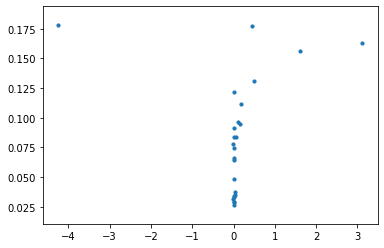

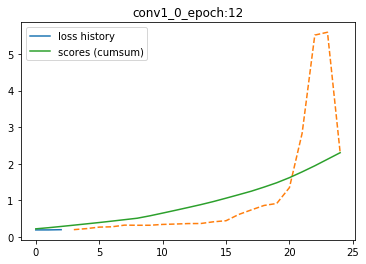

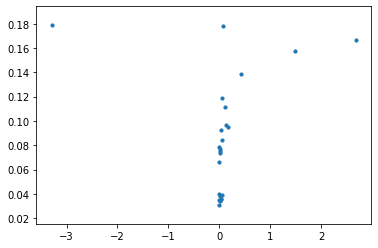

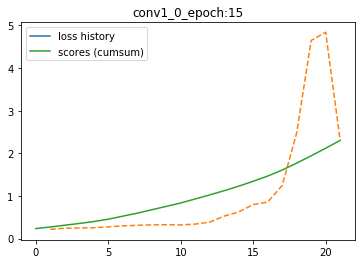

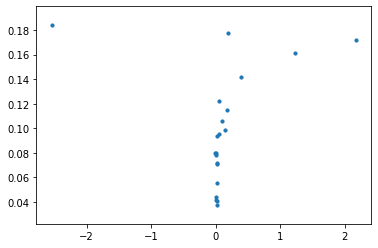

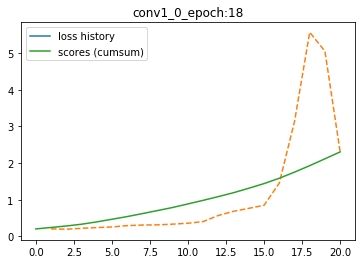

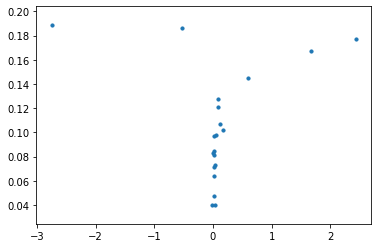

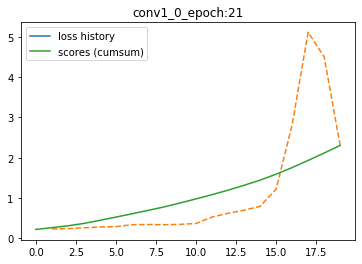

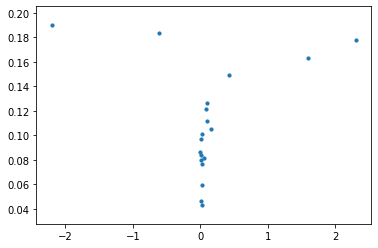

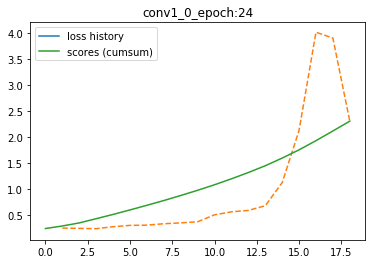

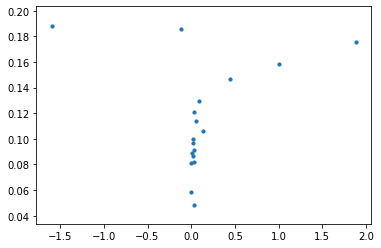

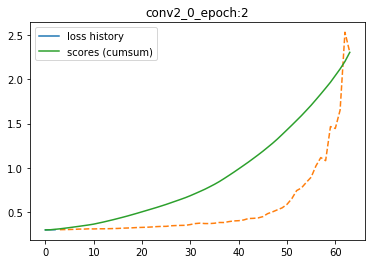

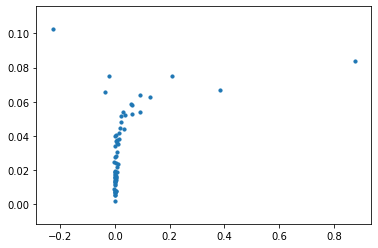

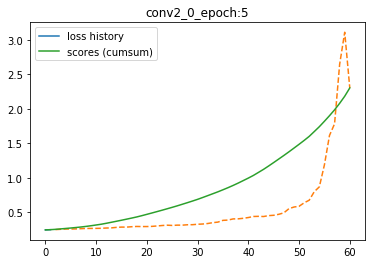

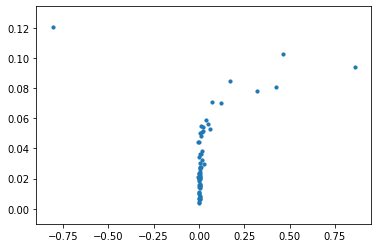

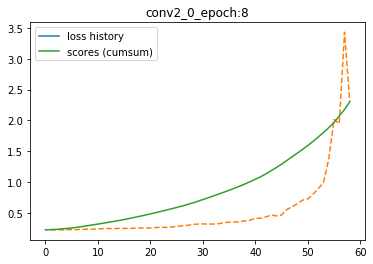

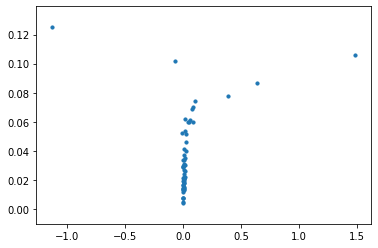

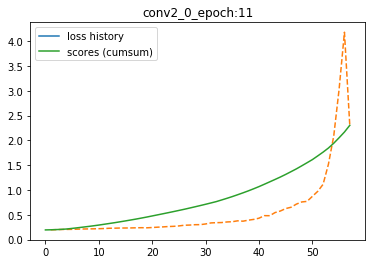

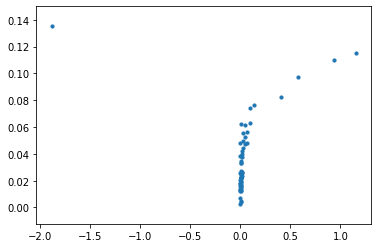

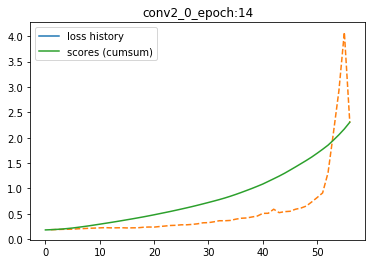

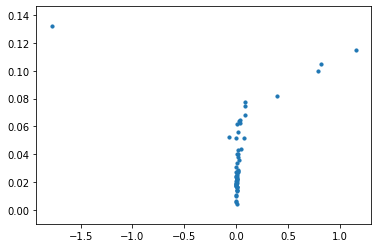

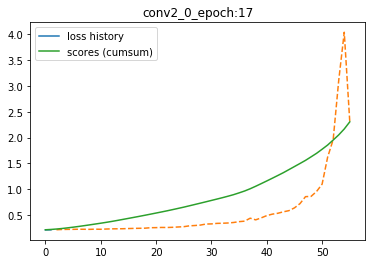

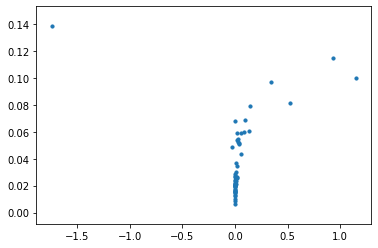

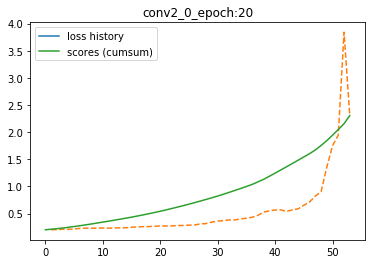

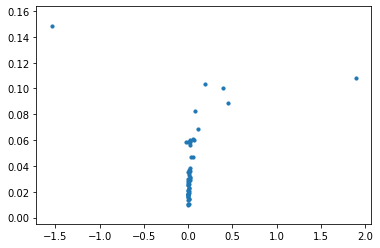

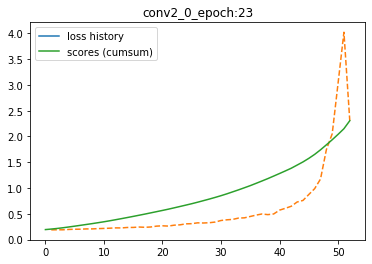

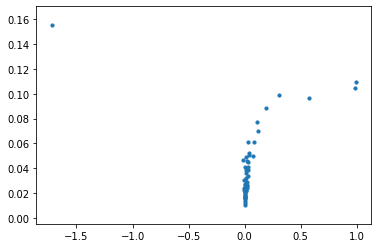

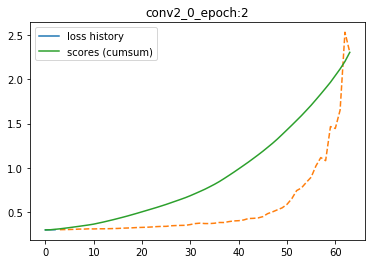

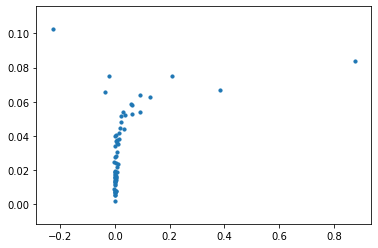

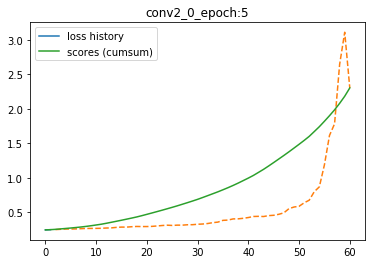

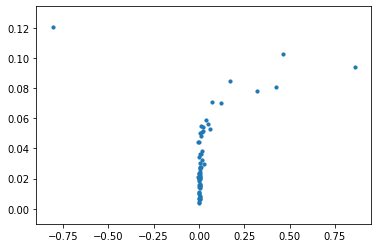

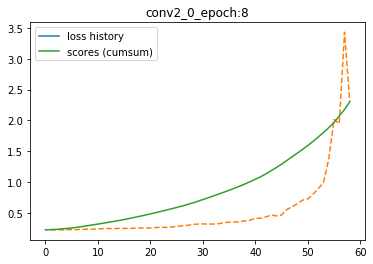

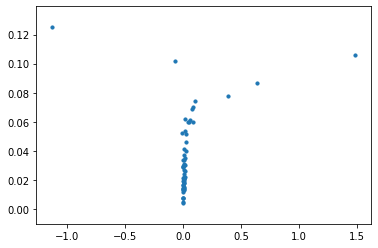

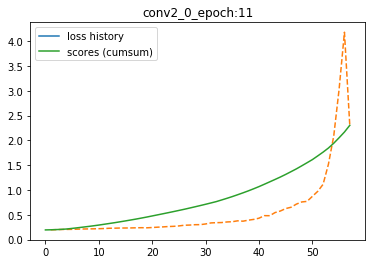

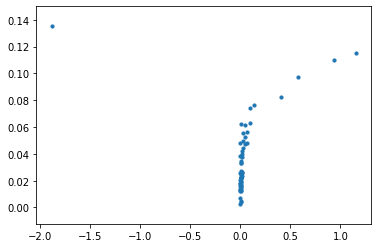

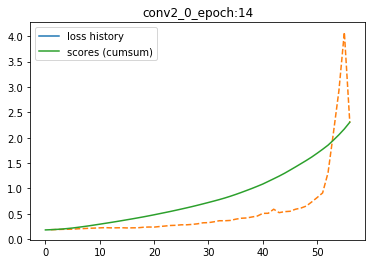

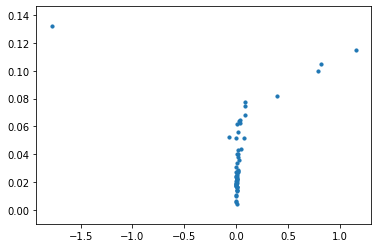

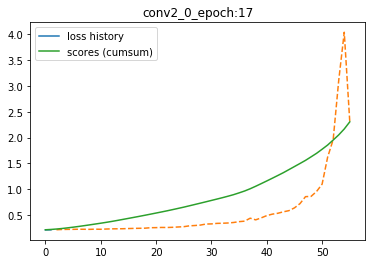

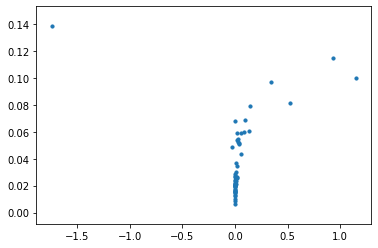

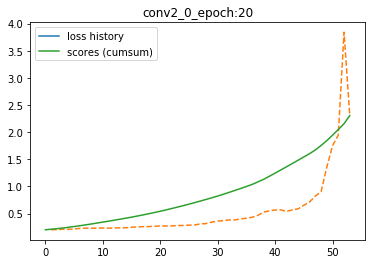

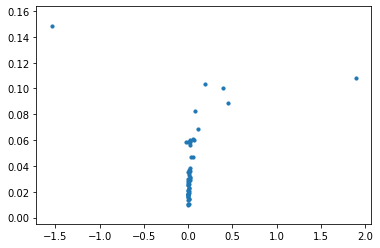

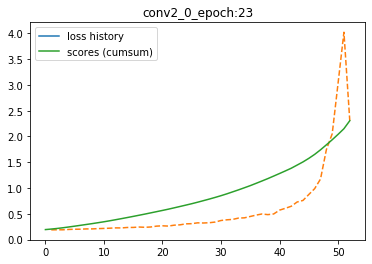

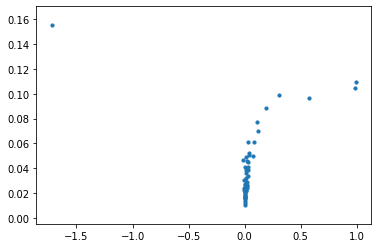

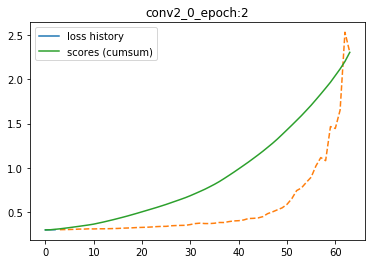

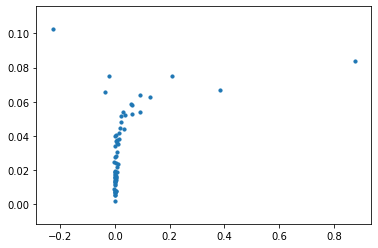

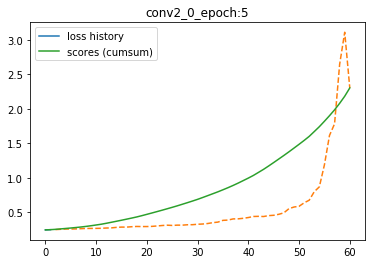

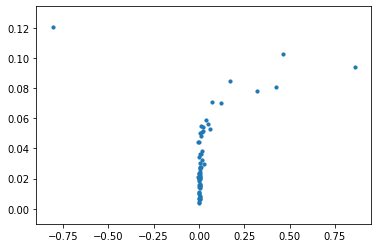

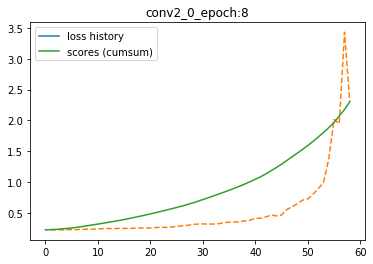

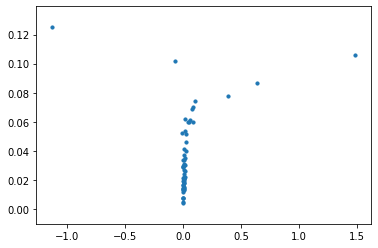

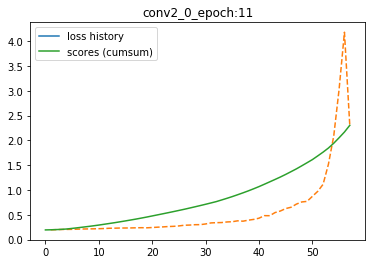

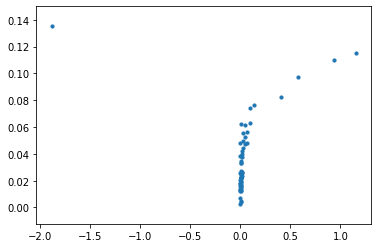

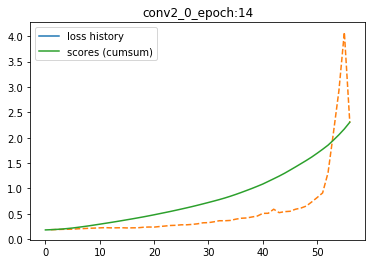

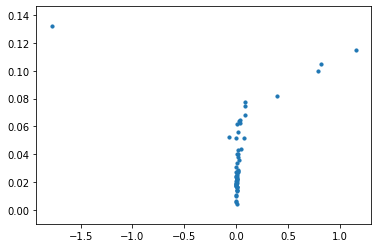

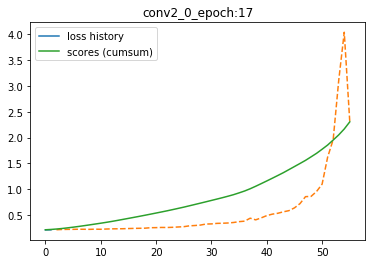

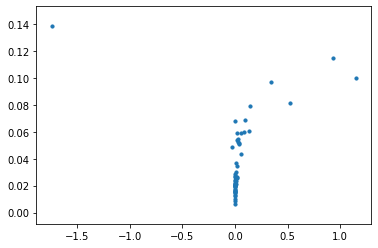

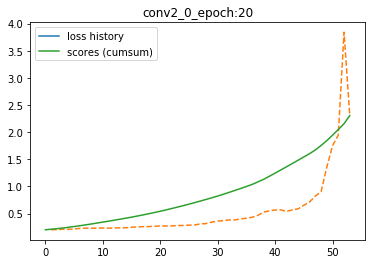

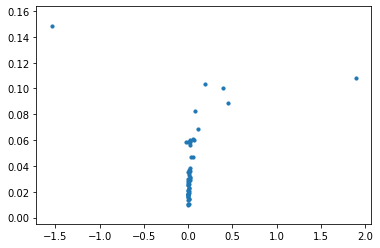

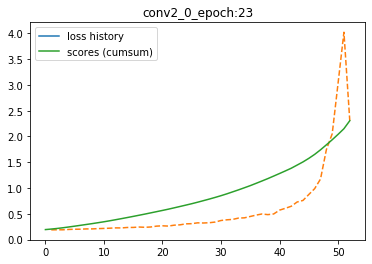

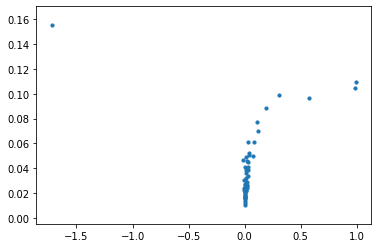

In [94]:
layers = ["fc1", "conv1", "conv2"]
N = len(data)
n = 1

for i in range(n):
    d = data.take(np.arange(N/n*i, N/n*(i+1)))
    for layer in layers:
        epochs = list(d[d["layer"].str.contains(layer)]["epoch"])
        for epoch in epochs:
            dd = d[d["epoch"] == epoch]
            loss = json.loads(list(dd[dd["layer"].str.contains(layer)]["loss_history"])[0])
            scores = json.loads(list(dd[dd["layer"].str.contains(layer)]["scores"])[0])
#             score = scores / np.sum(scores)
            full_loss = list(dd[dd["layer"].str.contains(layer)]["full_loss"])[0]
            empty_loss = loss[-1]
            scores = scores / np.sum(scores) * (empty_loss - full_loss)
            k = list(dd[dd["layer"].str.contains(layer)]["k"])[0]
            plt.figure()
            plt.plot(range(len(loss[:k])), loss[:k], label="loss history")
            plt.plot(k+np.arange(len(loss[k:])), loss[k:],  linestyle='dashed')
            plt.plot(range(len(scores)), np.array(scores).cumsum()+ full_loss, label="scores (cumsum)")
            plt.legend()
            plt.title(f"{layer}_{i}_epoch:{epoch}")
            plt.figure()
            plt.scatter(np.ediff1d(loss), np.array(scores)[1:], s=10)
            print (spearmanr(np.ediff1d(loss), scores[1:]))
        
            